# Autoencoder example

The goal here is to encode a "toy" beat data, represented as a shape (24, ) tensor of magnitudes, in a way that reflects the following metric generated by the following moves:
* Shifting a single beat by 1 should be distance 0.5.
* Removing a single beat should be distance 1.

Play with these values.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# A basic encoder/decoder with a single internal layer
# Allows for augmentation of the encoder, i.e. if we have already extracted some information from the data and want to use it in the encoding, it can be concatenated to it.
class EncoderDecoder(nn.Module):
    def __init__(self, in_size, out_size, mid_size, aug_size = 0):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_size, mid_size), 
            nn.ReLU(), 
            nn.Linear(mid_size, mid_size),
            nn.ReLU(),
            nn.Linear(mid_size, mid_size),
            nn.ReLU(),
            nn.Linear(mid_size, out_size))
        self.dec = nn.Sequential(
            nn.Linear(out_size + aug_size, mid_size), 
            nn.ReLU(), 
            nn.Linear(mid_size, mid_size),
            nn.ReLU(),
            nn.Linear(mid_size, mid_size),
            nn.ReLU(), 
            nn.Linear(mid_size, in_size))
        self.aug_size = aug_size

    def forward(self, x, a = None):
        return self.decode(self.encode(x, a))
    
    def encode(self, x, a = None):
        if a == None:
            a = torch.zeros((x.shape[0], self.aug_size))
        return torch.cat([self.enc(x), a], dim=1)
    
    def decode(self, x):
        return self.dec(x)


In [6]:
N = 10000

# The base data
x = torch.randint(high=2, size=(N,24))

# Target data
# For ith data, look for a 1 at position i % 24 and a 0 in position i % 25; if found, transpose, otherwise, skip
do_transpose = (x[torch.arange(N), torch.arange(N) % 24] == 1) & (x[torch.arange(N), (torch.arange(N) + 1) % 24] == 0)
# If there is a 1 at the first position and a 1 in the next position, drop it
do_drop = (x[torch.arange(N), torch.arange(N) % 24] == 1) & (x[torch.arange(N), (torch.arange(N) + 1) % 24] == 1)

y = x.detach().clone()

y[do_transpose, (torch.arange(N) % 24)[do_transpose]] = 0
y[do_transpose, ((torch.arange(N) + 1) % 24)[do_transpose]] = 1

y[do_drop, (torch.arange(N) % 24)[do_drop]] = 0


distances = torch.zeros(N)
distances[do_transpose] = 0.5
distances[do_drop] = 1

Train 4000 iterations with full batch.

Iteration 1 loss 11.625568389892578
Iteration 2 loss 11.201728820800781
Iteration 3 loss 10.002177238464355
Iteration 4 loss 7.765338897705078
Iteration 5 loss 6.0670013427734375
Iteration 6 loss 6.295544624328613
Iteration 7 loss 5.60684061050415
Iteration 8 loss 6.159659385681152
Iteration 9 loss 6.222299098968506
Iteration 10 loss 5.867192268371582
Iteration 11 loss 5.774085521697998
Iteration 12 loss 5.985645294189453
Iteration 13 loss 5.747470378875732
Iteration 14 loss 5.598006248474121
Iteration 15 loss 5.664076805114746
Iteration 16 loss 5.748331069946289
Iteration 17 loss 5.694278240203857
Iteration 18 loss 5.532658100128174
Iteration 19 loss 5.598372936248779
Iteration 20 loss 5.769241809844971
Iteration 21 loss 5.563508033752441
Iteration 22 loss 5.597104072570801
Iteration 23 loss 5.589698791503906
Iteration 24 loss 5.623269081115723
Iteration 25 loss 5.655639171600342
Iteration 26 loss 5.473281383514404
Iteration 27 loss 5.563162803649902
Iteration 28 loss 5.54794025421142

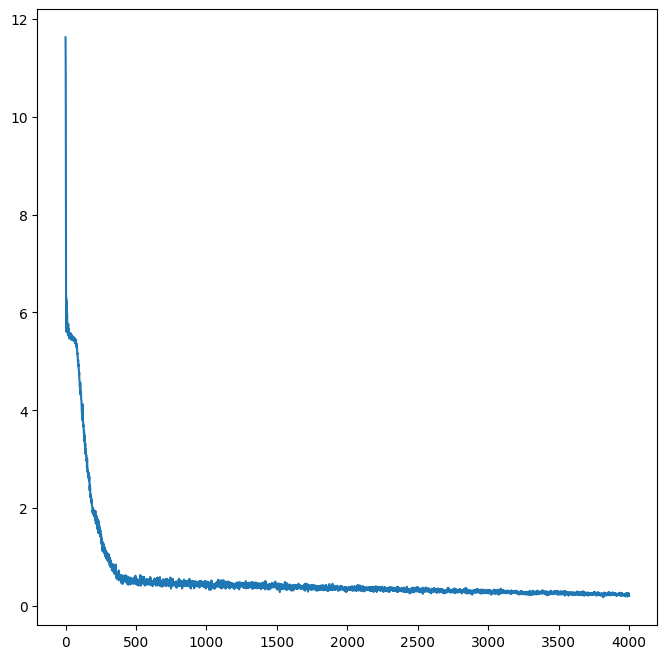

In [7]:

m = EncoderDecoder(24, 128, 512)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
losses = []

batch_size = 256
iterations = 4000

for i in range(iterations):
    ind = torch.randint(0, x.shape[0], (batch_size,))
    u = m.forward(x[ind].float())
    loss = torch.abs(((u - y[ind]) ** 2).sum(axis=1) - distances[ind] ** 2).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    print(f"Iteration {i+1} loss {loss.item()}")



plt.figure(figsize=(8,8))
plt.plot(range(len(losses)), losses)


In [8]:
u = m.forward(x.float())

torch.abs(((u - y) ** 2).sum(axis=1) - distances ** 2).mean()


tensor(0.2363, grad_fn=<MeanBackward0>)

Generate test data

In [9]:
N = 1000

# The base data
x = torch.randint(high=2, size=(N,24))

# Target data
# For ith data, look for a 1 at position i % 24 and a 0 in position i % 25; if found, transpose, otherwise, skip
do_transpose = (x[torch.arange(N), torch.arange(N) % 24] == 1) & (x[torch.arange(N), (torch.arange(N) + 1) % 24] == 0)
# If there is a 1 at the first position and a 1 in the next position, drop it
do_drop = (x[torch.arange(N), torch.arange(N) % 24] == 1) & (x[torch.arange(N), (torch.arange(N) + 1) % 24] == 1)

y = x.detach().clone()

y[do_transpose, (torch.arange(N) % 24)[do_transpose]] = 0
y[do_transpose, ((torch.arange(N) + 1) % 24)[do_transpose]] = 1

y[do_drop, (torch.arange(N) % 24)[do_drop]] = 0


distances = torch.zeros(N)
distances[do_transpose] = 0.5
distances[do_drop] = 1


u = m.forward(x.float())
torch.abs(((u - y) ** 2).sum(axis=1) - distances ** 2).mean()


tensor(0.6972, grad_fn=<MeanBackward0>)